# Leduc Poker - CFR Algorithm

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle, seed
import time
import sys
import networkx as nx


In [3]:
from sre_constants import CATEGORY_LOC_WORD
class LeducGame:
    def __init__(self):
        '''Constructeur Self'''
        self.expected_game_value = 0
        self.n_cards = 6
        self.nash_equilibrium = dict()
        self.current_player = 0
        self.deck = np.array(["1h", "1d", "2h", "2d", "3h", "3d"])
        self.n_actions = 2
        self.num_bet = 2
        self.betting_round = 1
        self.common_card = ""
        self.edge_list = []
        self.nodeMap = {}
        self.stratDict = {}

    def train(self, n_iterations=50000):
        '''Entraine le modèle en utilisant l'algo CFR'''
        expected_game_value = 0
        seed(42)
        for _ in range(n_iterations):
            shuffle(self.deck) #Pour mélanger le deck
            self.common_card = self.deck[2]
            self.betting_round = 1
            expected_game_value += self.cfr("", 1, 1)
            for key, v in self.nodeMap.items():
                v.update_strategy()

        expected_game_value /= n_iterations
        display_results(expected_game_value, self.nodeMap)

        #print(self.get_StrategyModel())
        return

    def cfr(self, history, pr_1, pr_2):
        assert len(history) < self.num_bet * 4
        '''Algorithme CFR'''
        #History = Sequence of action until the node considered
        #pr_1 = Probability from player 1 to get to this node
        #pr_2 = Probability from player 2 to get to this node

        n_last_round = 0

        if ('r' not in history):
            self.betting_round = 1

        if (self.betting_round > 1):
            n_last_round = list(reversed(list(history))).index('r')
        else:
            n_last_round = len(history)

        is_player_1 = (n_last_round % 2 == 0)

        player_card = self.deck[0] if is_player_1 else self.deck[1]
        #opponent_card = self.deck[1] if is_player_1 else self.deck[0]
        if ('r' in history):
            player_card = player_card + self.common_card
            #opponent_card = opponent_card + self.common_card

        if self.is_terminal(history):
            opponent_card = self.deck[1] if is_player_1 else self.deck[0]
            if ('r' in history):
                opponent_card = opponent_card + self.common_card
            return self.get_reward(history, player_card, opponent_card)

        node = self.get_node(player_card, history)
        strategy = node.strategy

        # Counterfactual utility per action #Gain par action
        action_utils = np.zeros(self.n_actions)

        for act in range(self.n_actions):

            next_history = history + node.action_dict[act]
            edge = (history, next_history)

            if edge not in self.edge_list:
                self.edge_list.append(edge)

            if (next_history[-2:] == "bb") and (self.betting_round != self.num_bet):

                #We have reached the end of a betting turn
                save_history = next_history
                next_history = next_history + "r"
                random_edge = (save_history, next_history)
                self.betting_round += 1

                #Card reveal
                ###CHECK UPDATE
                #node = self.get_node(player_card + self.common_card, next_history)
                #strategy = node.strategy

                if random_edge not in self.edge_list:
                  self.edge_list.append(random_edge)

            # -1 pour se placer du point de vue de l'autre joueur à chaque progression dans l'arbre du jeu
            if is_player_1:
                action_utils[act] = -1 * self.cfr(next_history, pr_1 * strategy[act], pr_2)
            else:
                action_utils[act] = -1 * self.cfr(next_history, pr_1, pr_2 * strategy[act])

        #Utility of information set
        util = sum(action_utils * strategy)
        regrets = action_utils - util

        if is_player_1:
            node.reach_pr += pr_1
            node.regret_sum += pr_2 * regrets
        else:
            node.reach_pr += pr_2
            node.regret_sum += pr_1 * regrets

        return util

    def is_terminal(self, history):
        '''Valide si le noeud correspond est un noeud final'''
        isTerminal = False
        isTerminal = isTerminal or (history[-2:] == "pp")
        isTerminal = isTerminal or (history[-2:] == "bp")
        isTerminal = isTerminal or ((history[-2:] == "bb") and (self.betting_round == self.num_bet))
        return isTerminal

    def get_reward(self, history, player_card, opponent_card):
        '''Renvoie la recompense associée à l'historique du jeu'''
        terminal_pass = (history[-1] == 'p')
        double_bet = (history[-2:] == 'bb')
        bet = self.getBet(self.betting_round, player_card, opponent_card)
        if terminal_pass:
            if history[-2] == 'pp':
                return bet if self.compareSet(player_card, opponent_card) else -bet
            else:
                return self.betting_round
        elif double_bet:
            return bet + 1 if self.compareSet(player_card, opponent_card) else -(bet + 1)

    @staticmethod
    def getBet(bet, player_card, opponent_card):
        '''Renvoie le gain positif de la partie'''
        if player_card[0] == opponent_card[0]:
            return 0
        return bet

    def compareSet(self, player_card, opponent_card):
        '''Renvoie vrai si le joueur gagne sur son opposant'''
        if player_card[0] == self.common_card[0]:
            return True
        elif opponent_card[0] == self.common_card[0]:
            return False
        return player_card[0] >= opponent_card[0]


    def get_node(self, card, history):
        '''Renvoie le noeud correspondant suivant l'historique de jeu'''
        key = str(card) + " " + history
        if key not in self.nodeMap:
            action_dict = {0: 'p', 1: 'b'}
            self.nodeMap[key] = Node(key, action_dict)
        return self.nodeMap[key]

    def get_nodeMap(self):
        return self.nodeMap

    def get_unitaryNodeMap(self):
        '''Renvoie graphe unitaire du jeu de poker'''
        G = nx.DiGraph()
        #edge_list = intoGraph(num_bet = num_bet, actions = actions, history = "", edge_list = [], round = 1)
        G.add_edges_from(self.edge_list)
        pos = nx.planar_layout(G)

        print("Edge List : {}".format(self.edge_list))

        # Dessin du graphe
        nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray')
        return G

    def set_StrategyModel(self):
        '''Construit l'arbre des strategies suivant les cartes et les actions des joueurs'''

        for key, node in self.nodeMap.items():

            stratDict = self.stratDict

            keys = key.split()
            cards, actions = "", ""

            if(len(keys) == 2):
                cards, actions = keys[0], keys[1]
            else:
                cards = keys[0]

            chemin = []
            for i in range(0, len(cards), 2):
                chemin.append(cards[i:i+2])
            chemin.append("act")
            chemin = chemin + list(actions)
            chemin.append("strat")

            strategy = node.get_average_strategy()

            self.add_StrategyBranch(self.stratDict, chemin, strategy)

        return

    def add_StrategyBranch(self, noeud, chemin, strategy, profondeur = 0):
        """Ajouter une branche à l'arbre à une position spécifiée par chemin"""
        if profondeur == len(chemin):
            noeud["val"] = strategy
            return

        if chemin[profondeur] not in noeud.keys():
            noeud[chemin[profondeur]] = {}

        return self.add_StrategyBranch(noeud[chemin[profondeur]], chemin, strategy, profondeur + 1)

    def get_StrategyModel(self):
        '''Renvoie le modèle des stratéges'''
        return self.stratDict

    def botPoker(self, cards, actions):
        '''Fonction executive pour accéder à la meilleur strategie suivant cards et actions'''
        stratDict = self.stratDict

        #Mise en forme des cartes et actions
        cardsList = []
        actionsList = list(actions)
        for i in range(0, len(cards), 2):
            cardsList.append(cards[i:i+2])

        #Parcours du graphe du modèle de stategy
        for card in cardsList:
            stratDict = stratDict[card]

        stratDict = stratDict["act"]

        for action in actionsList:
            stratDict = stratDict[action]

        strategy = stratDict["strat"]

        return strategy["val"]


In [4]:
def display_results(ev, i_map):
    print('player 1 expected value: {}'.format(ev))
    print('player 2 expected value: {}'.format(-1 * ev))

    print()
    print('player 1 strategies:')
    sorted_items = sorted(i_map.items(), key=lambda x: x[0])
    for _, v in filter(lambda x: x[1].is_player_1(), sorted_items):
        print(v)
    print()
    print('player 2 strategies:')
    for _, v in filter(lambda x: not x[1].is_player_1(), sorted_items):
        print(v)

In [5]:
class Node:
    def __init__(self, key, action_dict, n_actions = 2):
        self.key = key
        self.n_actions = n_actions

        #Sum of difference between counter factual reward and actual reward
        self.regret_sum = np.zeros(self.n_actions)
        self.strategy_sum = np.zeros(self.n_actions)

        #Possible action
        self.action_dict = action_dict

        #Probability of each possible action in a node
        self.strategy = np.repeat(1/self.n_actions, self.n_actions)

        #Probability of reaching this node on the game tree
        self.reach_pr = 0
        self.reach_pr_sum = 0

        self.num_updates = 0

    def update_strategy(self):
        self.strategy_sum += self.reach_pr * self.strategy
        self.reach_pr_sum += self.reach_pr
        self.strategy = self.get_strategy()
        self.num_updates += 1
        self.reach_pr = 0

        #if (self.reach_pr == 0): #Regler probleme du reach_pr == 0
            #print("DEBUG A")
        #if (sum(self.strategy) == 0):
        #     print("DEBUG B")

    def get_strategy(self):
        regrets = self.regret_sum
        #Resolve problem with strategy = [x, 0] which influence pr_1 for action = 'pb'
        regrets[regrets < 0] = 0 #After each iteration, if regret < 0, set regret = 0 #CFR +
        normalizing_sum = sum(regrets)
        if normalizing_sum != 0:
            return regrets / normalizing_sum
        else:
            return np.repeat(1/self.n_actions, self.n_actions)

    def get_average_strategy(self):
        #When computing weight average strategy weigh iteration t by t #CFR +

        average_strategy = self.strategy_sum
        total = sum(average_strategy)
        if(total != 0):
            average_strategy /= total
        else:
           print("ERROR GET AVERAGE STRAT / reach_pr_sum = {} / average_strategy = {}".format(self.reach_pr_sum, average_strategy))
        return average_strategy

    def is_player_1(self):
        if ('r' in self.key):
            n_last_round = list(reversed(list(self.key))).index('r')
            return (n_last_round % 2 == 0)
        return (len(self.key) % 2 == 1)

    def get_key(self):
        return self.key

    def __str__(self):
        strategies = ['{:03.2f}'.format(x) for x in self.get_average_strategy()]
        return '{} {} {}'.format(self.key.ljust(30), strategies, self.num_updates)

In [6]:
#A faire
#Leduc Poker
#resolve <ipython-input-4-2be46f80e384>:38: RuntimeWarning: invalid value encountered in divide
  #strategy = self.strategy_sum / self.reach_pr_sum
#Adapt Average strategie with CFR+
#Adapt calcul of regret with CFR+ (Alternates between both players, updating regrets for only one players) (Reduce amount of game tree explored each iteration)
#Pruning - Don't consider small regret (A partir d'un certain nombre d'iteration)


#Flop Hold'em Poker (Like Texas Holdem but only two betting rounds, 3 community cards) (First do for only pair, then others combinaisons)
#Rhode Island Poker (One pocket card, 4 community cardds, 3 betting rounds)
#Royal Holdem (Exaclty like Texas Holdem but the deck only contains cards 10 or higher)
#Texas Holdem Head's up
#Texas Holdem limit (6 players)
#Texas Holdem No Limit (6 players)
#See Deep CFR and ReBel

#1500 iterations to get Nash Equilibrium

player 1 expected value: 0.5043289571823532
player 2 expected value: -0.5043289571823532

player 1 strategies:
1d                             ['0.92', '0.08'] 9994
1d pb                          ['0.01', '0.99'] 9994
1d1h bbr                       ['0.86', '0.14'] 9992
1d1h bbrpb                     ['0.00', '1.00'] 9992
1d1h pbbr                      ['0.90', '0.10'] 9992
1d1h pbbrpb                    ['0.00', '1.00'] 9992
1d2d bbr                       ['0.85', '0.15'] 9994
1d2d bbrpb                     ['0.97', '0.03'] 9994
1d2d pbbr                      ['0.04', '0.96'] 9994
1d2d pbbrpb                    ['0.56', '0.44'] 9994
1d2h bbr                       ['0.85', '0.15'] 9988
1d2h bbrpb                     ['0.96', '0.04'] 9988
1d2h pbbr                      ['0.07', '0.93'] 9988
1d2h pbbrpb                    ['0.85', '0.15'] 9988
1d3d bbr                       ['0.85', '0.15'] 9979
1d3d bbrpb                     ['0.97', '0.03'] 9979
1d3d pbbr                      ['0.05', '

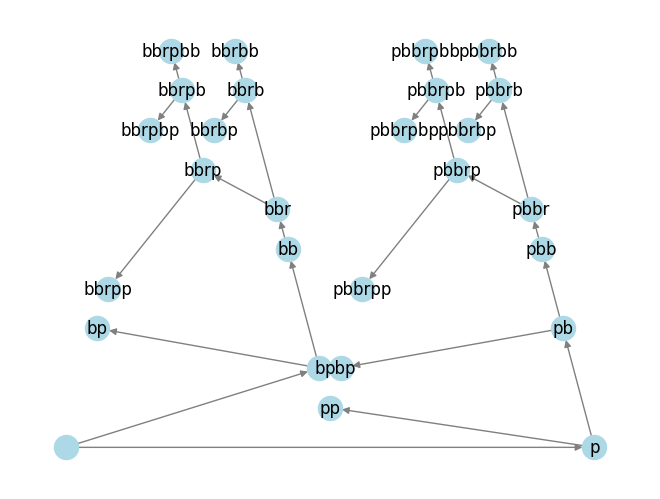

In [9]:
if __name__ == "__main__":
    time1 = time.time()
    trainer = LeducGame()
    trainer.train(n_iterations=10000)
    trainer.get_unitaryNodeMap()

    print()
    print("Temps de calcul : {} secondes".format(abs(time1 - time.time())))
    #print("Nombre de noeud : {}".format(sys.getsizeof(trainer)))
    print("Nombre de noeud : {}".format((len(trainer.edge_list) + 1)*trainer.n_cards*(trainer.n_cards-1)*trainer.n_cards-2)) #4498 noeuds

In [8]:
#Set Strategy Model Into Dictionnary

trainer.set_StrategyModel()
print(trainer.get_StrategyModel()) #To get the strategy dictionnary
#1d3d bbrpb      ['0.79', '0.21']
best_strategy = trainer.botPoker("1d3d", "bbrpb")
print(best_strategy)


{'2d': {'act': {'strat': {'val': array([0.21447882, 0.78552118])}, 'p': {'b': {'strat': {'val': array([0.15820745, 0.84179255])}}, 'strat': {'val': array([0.58882563, 0.41117437])}}, 'b': {'strat': {'val': array([0.34675202, 0.65324798])}}}, '2h': {'act': {'p': {'b': {'b': {'r': {'strat': {'val': array([0.63018428, 0.36981572])}, 'p': {'b': {'strat': {'val': array([0.01056437, 0.98943563])}}, 'strat': {'val': array([0.01459728, 0.98540272])}}, 'b': {'strat': {'val': array([0.01459728, 0.98540272])}}}}}}, 'b': {'b': {'r': {'strat': {'val': array([0.50666959, 0.49333041])}, 'p': {'b': {'strat': {'val': array([0.0091157, 0.9908843])}}, 'strat': {'val': array([0.01248598, 0.98751402])}}, 'b': {'strat': {'val': array([0.01248598, 0.98751402])}}}}}}}, '3h': {'act': {'p': {'b': {'b': {'r': {'strat': {'val': array([0.46805631, 0.53194369])}, 'p': {'b': {'strat': {'val': array([0.18116991, 0.81883009])}}, 'strat': {'val': array([0.08951955, 0.91048045])}}, 'b': {'strat': {'val': array([0.037544